In [67]:
import pandas as pd

data = pd.read_json('../data/data.json')
data.head()

,FECHA,TEMPERATURA,SALINIDAD,STATION,UI,UI_1,UI_2,UI_3,UI_4,PSEUSPP,BLOOM,BLOOM_1w,BLOOM_2w,BLOOM_PREDICT,CA_G_1,RIA,DAY,VAR_TEMPERATURA,VAR_SALINIDAD,COD_BLOOM
0,2002-01-02T00:00:00.000,13.2759,35.4888,V5,-4500.0250,NaN,NaN,NaN,NaN,0,-1,NaN,NaN,-1,0.266,4,2,NaN,NaN,0
1,2002-01-07T00:00:00.000,13.0745,35.4060,V5,-69.8435,-4500.0250,NaN,NaN,NaN,0,-1,-1.0,NaN,-1,0.970,4,7,-0.2014,-0.0828,0
2,2002-01-14T00:00:00.000,13.3759,35.4253,V5,-267.5175,-69.8435,-4500.0250,NaN,NaN,0,-1,-1.0,-1.0,-1,0.536,4,14,0.3014,0.0193,0
3,2002-01-21T00:00:00.000,13.2589,35.4342,V5,-4402.3525,-267.5175,-69.8435,-4500.0250,NaN,0,-1,-1.0,-1.0,-1,0.454,4,21,-0.1170,0.0089,0
4,2002-01-28T00:00:00.000,13.4761,35.0551,V5,-957.6475,-4402.3525,-267.5175,-69.8435,-4500.025,0,-1,-1.0,-1.0,-1,0.382,4,28,0.2172,-0.3791,0


In [ ]:
data['CA_G_1_1w'] = data['CA_G_1'].shift(1) # añadir el valor previo (1 semana) de CA_G_1 -> Clorofila d 

In [68]:
data.isna().sum()[data.isna().sum() > 0]

UI                 25
UI_1               29
UI_2               33
UI_3               37
UI_4               41
BLOOM_1w            4
BLOOM_2w            8
CA_G_1             10
VAR_TEMPERATURA     4
VAR_SALINIDAD       4
dtype: int64

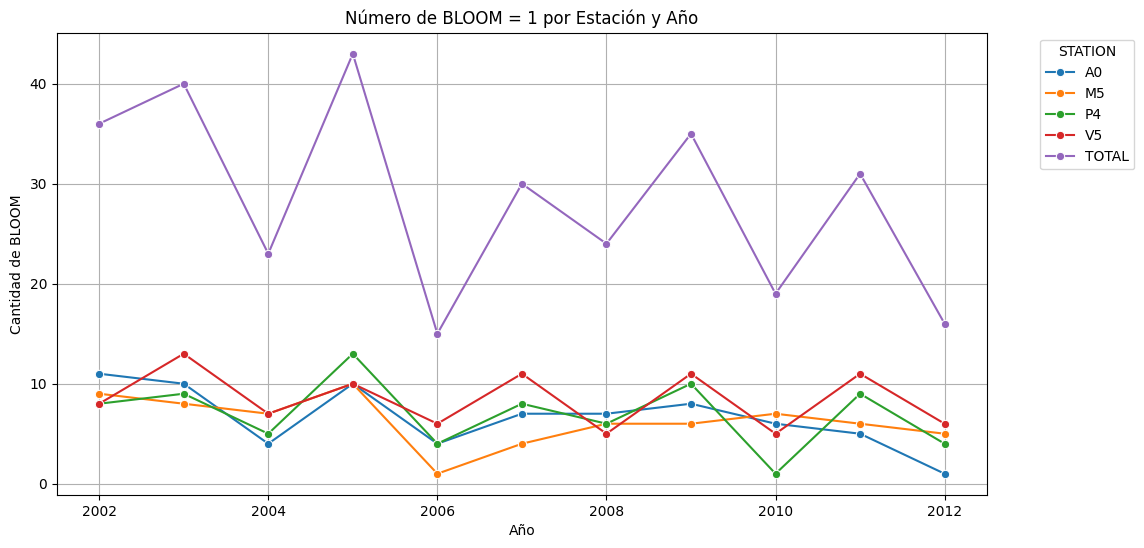

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

data['FECHA'] = pd.to_datetime(data['FECHA'], errors='coerce')
# Asegurar que 'FECHA' es de tipo datetime y extraer el año
data['AÑO'] = data['FECHA'].dt.year

# Contar BLOOM = 1 por cada estación y año
bloom_por_estacion = data[data['BLOOM'] == 1].groupby(['AÑO', 'STATION']).size().reset_index(name='COUNT')

# Calcular el total de BLOOM = 1 por año en todas las estaciones
bloom_total = bloom_por_estacion.groupby('AÑO')['COUNT'].sum().reset_index()
bloom_total['STATION'] = 'TOTAL'  # Para diferenciar en la gráfica

# Unir los datos de estaciones individuales con el total
bloom_final = pd.concat([bloom_por_estacion, bloom_total])

# Crear la gráfica
plt.figure(figsize=(12, 6))
sns.lineplot(data=bloom_final, x='AÑO', y='COUNT', hue='STATION', marker='o')

# Personalización del gráfico
plt.xlabel('Año')
plt.ylabel('Cantidad de BLOOM')
plt.title('Número de BLOOM = 1 por Estación y Año')
plt.legend(title='STATION', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Mostrar el gráfico
plt.show()

In [70]:
from sklearn.preprocessing import LabelEncoder

# Inicializar el LabelEncoder
le = LabelEncoder()

# Aplicar LabelEncoder a la columna STATION
data['STATION'] = le.fit_transform(data['STATION'])

# Verificar el resultado
print(data[['STATION']].head())
print(data['STATION'].value_counts())

   STATION
0        3
1        3
2        3
3        3
4        3
STATION
3    565
0    526
2    518
1    448
Name: count, dtype: int64


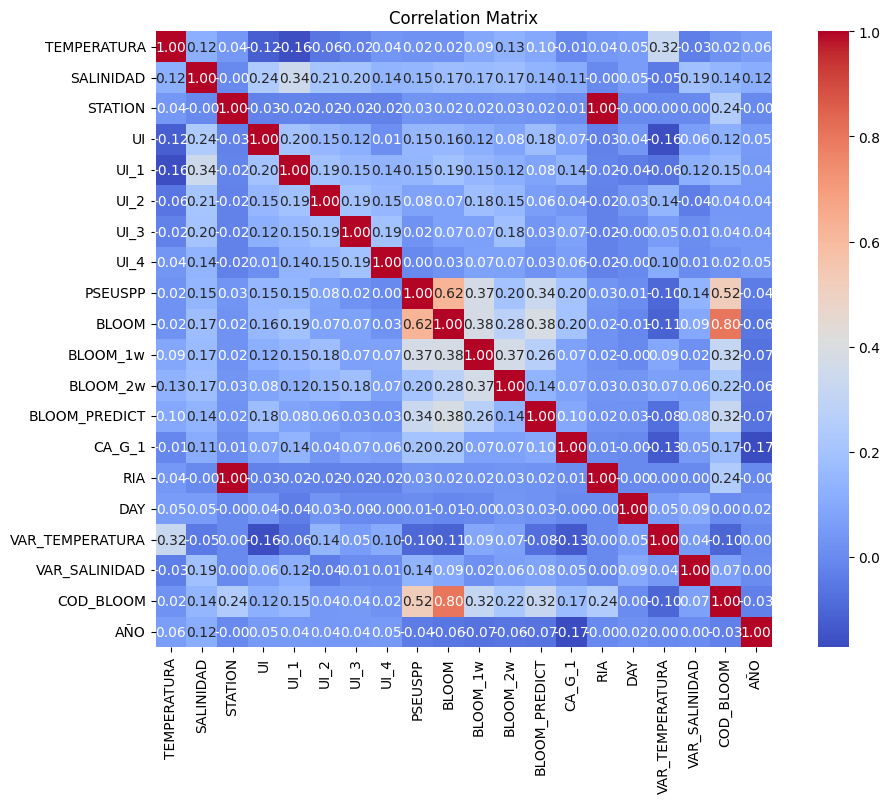

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Copia del DataFrame para evitar modificar el original
data_scaled = data.copy()

# Eliminar la columna FECHA
data_scaled = data_scaled.drop(columns=['FECHA'])

# Convertir todo a float64 antes de escalar
data_scaled = data_scaled.astype('float64')

# Aplicar MinMaxScaler a todas las columnas (escalado entre -1 y 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled.iloc[:, :] = scaler.fit_transform(data_scaled)

# Calcular la matriz de correlación
correlation_matrix = data_scaled.corr()

# Mostrar la matriz de correlación como un heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True, square=True)
plt.title('Correlation Matrix')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, cohen_kappa_score

# Preprocesamiento de los datos (Asegúrate de que 'BLOOM_PREDICT' esté en las categorías que desees predecir)
data = data.dropna()
print(data.shape)
X = data.drop(columns=['FECHA','BLOOM_PREDICT'])  # Ajusta según las columnas de tu dataset
y = data['BLOOM_PREDICT']

# Asegurarse de que las características estén en formato numérico (por ejemplo, usando get_dummies si tienes variables categóricas)
X = pd.get_dummies(X)

# Escalado de las características entre -1 y 1
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

# Definir los modelos a probar
kernels = ['rbf', 'poly']
degree_list = [2, 3, 4, 5]

# Función para calcular la especificidad
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

# Función para generar métricas y mostrar resultados
def get_metrics(model, X_train, X_val, y_train, y_val, kernel, degree=None):
    # Entrenar el modelo
    if kernel == 'poly' and degree is not None:
        model = SVC(kernel=kernel, degree=degree)
    else:
        model = SVC(kernel=kernel)
    
    model.fit(X_train, y_train)
    
    # Predicciones
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Matrices de confusión
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_train_pred).ravel()
    tn_val, fp_val, fn_val, tp_val = confusion_matrix(y_val, y_val_pred).ravel()
    
    # Cálculo de métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_sensitivity = recall_score(y_train, y_train_pred, average='weighted')
    train_specificity = specificity(y_train, y_train_pred)
    train_kappa = cohen_kappa_score(y_train, y_train_pred)
    
    # Cálculo de métricas para el conjunto de validación
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')
    val_precision = precision_score(y_val, y_val_pred, average='weighted')
    val_sensitivity = recall_score(y_val, y_val_pred, average='weighted')
    val_specificity = specificity(y_val, y_val_pred)
    val_kappa = cohen_kappa_score(y_val, y_val_pred)
    
    # Guardar y mostrar los resultados
    # return {
    #     'Kernel': kernel,
    #     'Degree': degree if kernel == 'poly' else None,
    #     'Train C+1': tp_train,  # Verdaderos Positivos en entrenamiento
    #     'Train C-1': fn_train,  # Falsos Negativos en entrenamiento
    #     'Train M+1': tn_train,  # Verdaderos Negativos en entrenamiento
    #     'Train M-1': fp_train,  # Falsos Positivos en entrenamiento
    #     'Train F1': train_f1,
    #     'Train Precision': train_precision,
    #     'Train Specificity': train_specificity,
    #     'Train Sensitivity': train_sensitivity,
    #     'Train Kappa': train_kappa,
    #     'Test C+1': tp_val,  # Verdaderos Positivos en validación
    #     'Test C-1': fn_val,  # Falsos Negativos en validación
    #     'Test M+1': tn_val,  # Verdaderos Negativos en validación
    #     'Test M-1': fp_val,  # Falsos Positivos en validación
    #     'Test F1': val_f1,
    #     'Test Precision': val_precision,
    #     'Test Specificity': val_specificity,
    #     'Test Sensitivity': val_sensitivity,
    #     'Test Kappa': val_kappa
    # }
    
    ## Según tesis Curro 
    return {
    'Kernel': kernel,
    'Degree': degree if kernel == 'poly' else None,
    'Train C+1': tp_train,  # Verdaderos Positivos en entrenamiento (Aciertos de bloom)
    'Train C-1': tn_train,  # Verdaderos Negativos en entrenamiento (Aciertos de no bloom)
    'Train M+1': fn_train,  # Falsos Negativos en entrenamiento (M+1)
    'Train M-1': fp_train,  # Falsos Positivos en entrenamiento (M-1)
    'Train F1': train_f1,
    'Train Precision': train_precision,
    'Train Specificity': train_specificity,
    'Train Sensitivity': train_sensitivity,
    'Train Kappa': train_kappa,
    'Test C+1': tp_val,  # Verdaderos Positivos en validación (Aciertos de bloom)
    'Test C-1': tn_val,  # Verdaderos Negativos en validación (Aciertos de no bloom)
    'Test M+1': fn_val,  # Falsos Negativos en validación (M+1)
    'Test M-1': fp_val,  # Falsos Positivos en validación (M-1)
    'Test F1': val_f1,
    'Test Precision': val_precision,
    'Test Specificity': val_specificity,
    'Test Sensitivity': val_sensitivity,
    'Test Kappa': val_kappa
}


# Crear un DataFrame vacío para almacenar los resultados
results = []

# Ejecutar para diferentes kernels y grados
for kernel in kernels:
    if kernel == 'poly':
        for degree in degree_list:
            metrics = get_metrics(SVC(), X_train, X_val, y_train, y_val, kernel, degree)
            results.append(metrics)
    else:
        metrics = get_metrics(SVC(), X_train, X_val, y_train, y_val, kernel)
        results.append(metrics)

# Convertir a DataFrame para mejor visualización
results_df = pd.DataFrame(results)

# Reestructurar el DataFrame a formato largo
long_results = pd.melt(results_df, 
                       id_vars=['Kernel', 'Degree'], 
                       value_vars=['Train C+1', 'Train C-1', 'Train M+1', 'Train M-1', 'Train F1', 'Train Precision', 'Train Specificity', 'Train Sensitivity', 
                                   'Train Kappa', 'Test C+1', 'Test C-1', 'Test M+1', 'Test M-1', 'Test F1', 'Test Precision', 
                                   'Test Specificity', 'Test Sensitivity', 'Test Kappa'], 
                       var_name='Metric', 
                       value_name='Score')

# Crear una nueva columna 'Data Type' para separar entrenamiento de validación
long_results['Data Type'] = long_results['Metric'].apply(lambda x: 'Train' if 'Train' in x else 'Val')

# Mostrar el DataFrame transformado
print(long_results)

# Guardar los resultados en un archivo CSV
long_results.to_csv('long_model_metrics_with_kappa.csv', index=False)

(1991, 21)
   Kernel  Degree      Metric      Score Data Type
0     rbf     NaN   Train C+1  49.000000     Train
1    poly     2.0   Train C+1  65.000000     Train
2    poly     3.0   Train C+1  61.000000     Train
3    poly     4.0   Train C+1  68.000000     Train
4    poly     5.0   Train C+1  78.000000     Train
..    ...     ...         ...        ...       ...
85    rbf     NaN  Test Kappa   0.236099       Val
86   poly     2.0  Test Kappa   0.272828       Val
87   poly     3.0  Test Kappa   0.268838       Val
88   poly     4.0  Test Kappa   0.230899       Val
89   poly     5.0  Test Kappa   0.205459       Val

[90 rows x 5 columns]


In [ ]:
from tabulate import tabulate

# Reemplazar NaN en la columna 'Degree' por 'N/A' o un valor representativo
long_results['Degree'] = long_results['Degree'].fillna("N/A")

# Filtrar los resultados para entrenamiento y validación
train_results = long_results[long_results['Data Type'] == 'Train']
val_results = long_results[long_results['Data Type'] == 'Val']

# Pivotar la tabla para tener las métricas en columnas separadas
train_pivot = train_results.pivot_table(index=['Kernel', 'Degree'], columns='Metric', values='Score')
val_pivot = val_results.pivot_table(index=['Kernel', 'Degree'], columns='Metric', values='Score')

# Convertir las tablas pivotadas en formato tabulate
train_table = tabulate(train_pivot, headers='keys', tablefmt='grid', showindex=True)
val_table = tabulate(val_pivot, headers='keys', tablefmt='grid', showindex=True)

# Mostrar las tablas
print("Tabla de Entrenamiento:")
print(train_table)

print("\nTabla de Validación:")
print(val_table)


Tabla de Entrenamiento:
+---------------+-------------+-------------+------------+---------------+-------------+-------------+-------------------+---------------------+---------------------+
|               |   Train C+1 |   Train C-1 |   Train F1 |   Train Kappa |   Train M+1 |   Train M-1 |   Train Precision |   Train Sensitivity |   Train Specificity |
+===============+=============+=============+============+===============+=============+=============+===================+=====================+=====================+
| ('poly', 2.0) |          65 |        1112 |   0.86317  |      0.399671 |         133 |          23 |          0.870218 |            0.882971 |            0.979736 |
+---------------+-------------+-------------+------------+---------------+-------------+-------------+-------------------+---------------------+---------------------+
| ('poly', 3.0) |          61 |        1121 |   0.864114 |      0.397733 |         137 |          14 |          0.879546 |            0.88672